# Bayesian Optimization for fMRI autoencoder

## Loading data

In [1]:
import sys

sys.path.append("..")

import tensorflow as tf

import tensorflow_probability as tfp

import numpy as np

import GPyOpt

import argparse

from utils import tf_config, preprocess_data, search_algorithms, train, bnn_utils, outlier_utils, eeg_utils, viz_utils

from models import fmri_ae

import matplotlib.pyplot as plt

import gc

import os

from sklearn.model_selection import train_test_split, KFold

import time

raw_eeg=False#time or frequency features? raw-time nonraw-frequency
resampling=False
dataset="01"
if(dataset=="01"):
    n_volumes=300-3
if(dataset=="02"):
    n_volumes=170-3
memory_limit=4000
n_individuals=10
n_individuals_train=8
n_individuals_test=2
#parametrize the interval eeg?
interval_eeg=6

tf_config.set_seed(seed=42)
tf_config.setup_tensorflow(device="GPU", memory_limit=memory_limit)

with tf.device('/CPU:0'):
    train_data, test_data = preprocess_data.dataset(dataset, n_individuals=n_individuals, 
                                                    interval_eeg=interval_eeg, 
                                                    ind_volume_fit=False,
                                                    standardize_fmri=True,
                                                    iqr=False,
                                                    verbose=True)
    _, fmri_train = train_data
    _, fmri_test = test_data

I: Starting to Load Data
I: Finished Loading Data
I: Pairs Created


## Hyperparameters to optimize

In [2]:
theta = (0.002980911194116198, 0.0004396489214334123, (9, 9, 4), (1, 1, 1), 1, (7, 7, 7), 4, True, True, True, True, 3, 1)

## Unpack hyperparameters

In [3]:
#unroll hyperparameters
learning_rate=float(theta[0])
weight_decay = float(theta[1])
kernel_size = theta[2]
stride_size = theta[3]
batch_size=int(theta[4])
latent_dimension=theta[5]
n_channels=int(theta[6])
max_pool=bool(theta[7])
batch_norm=bool(theta[8])
skip_connections=bool(theta[9])
dropout=bool(theta[10])
n_stacks=int(theta[11])
outfilter=int(theta[12])
local=True

## Build model

In [4]:
with tf.device('/CPU:0'):
    #build model
    model = fmri_ae.fMRI_AE(latent_dimension, fmri_train.shape[1:], kernel_size, stride_size, n_channels,
                        maxpool=max_pool, batch_norm=batch_norm, weight_decay=weight_decay, skip_connections=skip_connections,
                        n_stacks=n_stacks, local=True, local_attention=False, outfilter=outfilter, dropout=dropout)
    model.build(input_shape=fmri_train.shape)

    #train model
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    loss_fn = tf.keras.losses.MSE#replace

    train_set = tf.data.Dataset.from_tensor_slices((fmri_train, fmri_train)).batch(batch_size)
    test_set = tf.data.Dataset.from_tensor_slices((fmri_test, fmri_test)).batch(1)

## Train model

In [5]:
loss_history = train.train(train_set, model, optimizer, 
            loss_fn, epochs=10, 
            val_set=None, verbose=True)[0]

Epoch 1 with loss: 1.0561701848350276
Epoch 2 with loss: 0.040921928262745294
Epoch 3 with loss: 0.025957337759394773
Epoch 4 with loss: 0.019788907154257605
Epoch 5 with loss: 0.015064661627060483
Epoch 6 with loss: 0.0124652858042335
Epoch 7 with loss: 0.011290744377835813
Epoch 8 with loss: 0.011358937422160454
Epoch 9 with loss: 0.012454882635036083
Epoch 10 with loss: 0.014154298426881448


## Evaluate model

In [8]:
train.evaluate(test_set, model, loss_fn)

0.2672351031881018

## Train loss convergence

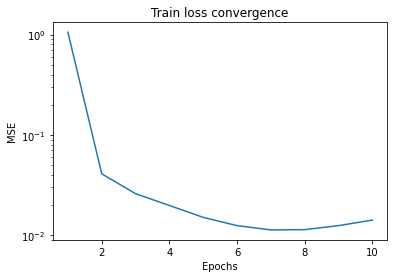

In [9]:
plt.figure()

plt.plot(np.arange(1,11,1), loss_history)
plt.xlabel("Epochs")
plt.ylabel("MSE")

plt.title("Train loss convergence")

plt.yscale("log")
plt.show()

## Visualize predicted slices

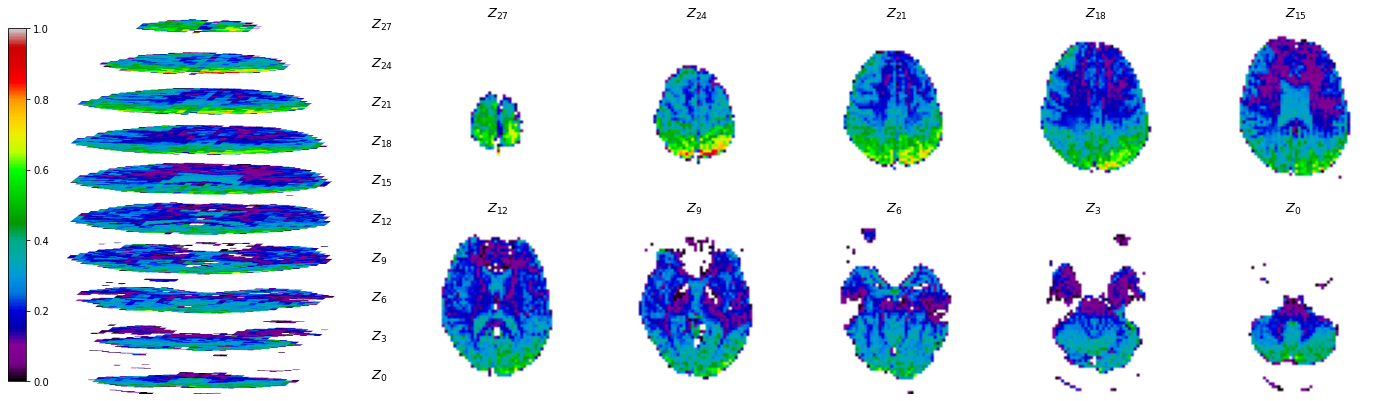

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


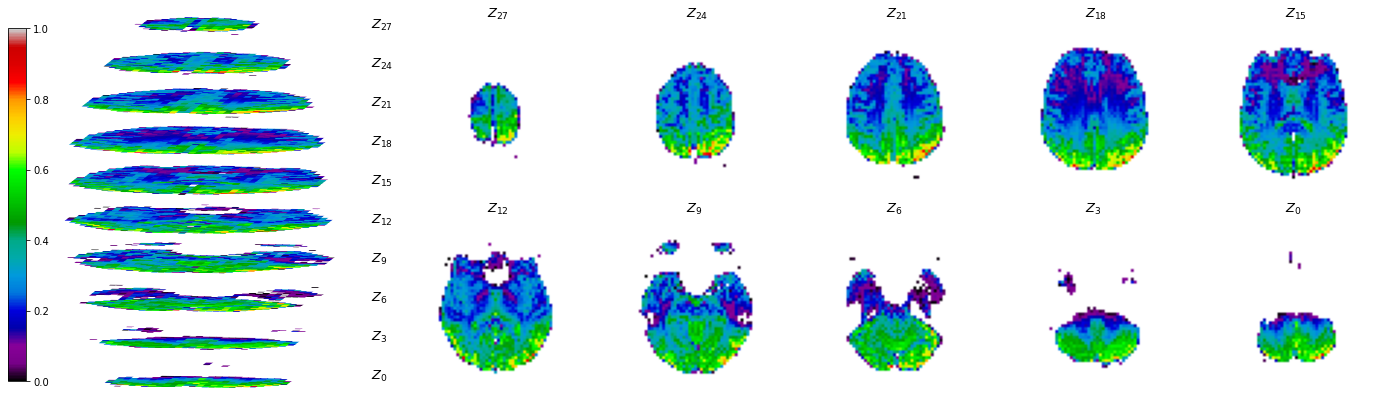

In [10]:
from utils import viz_utils

save_path = "/home/ist_davidcalhas/eeg_to_fmri/plots/fmri_ae/"

instance = 1
for instance_x, _ in test_set.repeat(1):
    fig = viz_utils.plot_3D_representation_projected_slices(instance_x.numpy()[0])
    #plt.savefig(save_path + str(instance) + "_ground_truth.pdf", format="pdf")
    
    fig = viz_utils.plot_3D_representation_projected_slices(model(instance_x).numpy()[0])
    #plt.savefig(save_path + str(instance) + "_predicted.pdf", format="pdf")
    fig
    break
    instance += 1